# Load Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


# Code

In [2]:
# 1. Load dataset (example: SMART CSV)
data = pd.read_csv('dataset/smart_manufacturing_data.csv', parse_dates=['timestamp'])
data = data.sort_values(['machine_id','timestamp']).reset_index(drop=True)
data.head()

,timestamp,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,failure_type,downtime_risk,maintenance_required
0,2025-01-01 01:37:00,1,62.59,48.08,60.13,1.62,4.16,1,0,363,Normal,0.0,0
1,2025-01-01 01:42:00,1,70.88,68.67,50.57,1.05,2.36,1,0,111,Normal,0.0,0
2,2025-01-01 02:13:00,1,62.34,72.68,60.47,2.24,4.95,1,0,192,Normal,0.0,0
3,2025-01-01 02:19:00,1,88.03,53.36,50.79,3.08,2.25,1,0,301,Normal,0.0,0
4,2025-01-01 03:05:00,1,79.39,49.44,56.99,2.54,2.76,1,0,127,Normal,0.0,0


In [3]:
print('Number of machines:', len(set(data['machine_id'].tolist())))
Counter(data["anomaly_flag"].tolist())

Number of machines: 50


Counter({0: 91084, 1: 8916})

Now, we only use 2 features out of 5

In [4]:
# 2. Scale and split features
# Split by machines
machine_train = list(range(1, 41)) # 1-40
machine_test = list(range(41, 51)) # 41-50

features = ["temperature", "vibration", "humidity", "pressure", "energy_consumption"]
# features = ["temperature", "vibration"]

X_train = data[data['machine_id'].isin(machine_train)][features]
X_test = data[data['machine_id'].isin(machine_test)][features]

y_train = data[data['machine_id'].isin(machine_train)]['anomaly_flag']
y_test = data[data['machine_id'].isin(machine_test)]['anomaly_flag']

In [5]:
print('Train:', len(y_train))
print('Test :', len(y_test))

print('Train:', Counter(y_train))
print('Test :', Counter(y_test))

Train: 80095
Test : 19905
Train: Counter({0: 73001, 1: 7094})
Test : Counter({0: 18083, 1: 1822})


EOFError: Ran out of input

In [7]:
with open('models/model_lgbm.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    
with open('models/model_lgbm_smaller.pkl', 'rb') as f:
    loaded_model_smaller = pickle.load(f)

Now we analyze the time taken for inference

In [26]:

# 5. Benchmark model size and inference latency
list_compute_time = []
list_compute_time_smaller = []

for i in range(1000):
    
    # Normal
    start = time.time()
    X_sample = [list(X_train.iloc[i])]
    scaler = StandardScaler()
    X_sample = scaler.fit_transform(X_sample)
    y_pred = loaded_model.predict(X_sample)
    list_compute_time.append(time.time()-start)

    # Smaller
    start = time.time()
    X_sample = [list(X_train.iloc[i])[0:2]]
    scaler = StandardScaler()
    X_sample = scaler.fit_transform(X_sample)
    y_pred = loaded_model_smaller.predict(X_sample)
    list_compute_time_smaller.append(time.time()-start)

list_compute_time = [x*1e6 for x in list_compute_time]
mean_time = np.mean(list_compute_time)
median_time = np.median(list_compute_time)
std_dev_time = np.std(list_compute_time)

# Display the results
print(f"Mean: {mean_time:.2f} micro-seconds")
print(f"Median: {median_time:.2f} micro-seconds")
print(f"Standard Deviation: {std_dev_time:.2f} micro-seconds")

list_compute_time_smaller = [x*1e6 for x in list_compute_time_smaller]
mean_time = np.mean(list_compute_time_smaller)
median_time = np.median(list_compute_time_smaller)
std_dev_time = np.std(list_compute_time_smaller)

# Display the results
print(f"Mean: {mean_time:.2f} micro-seconds")
print(f"Median: {median_time:.2f} micro-seconds")
print(f"Standard Deviation: {std_dev_time:.2f} micro-seconds")

Mean: 3240.88 micro-seconds
Median: 3007.53 micro-seconds
Standard Deviation: 1960.89 micro-seconds
Mean: 3294.17 micro-seconds
Median: 3003.00 micro-seconds
Standard Deviation: 2378.22 micro-seconds


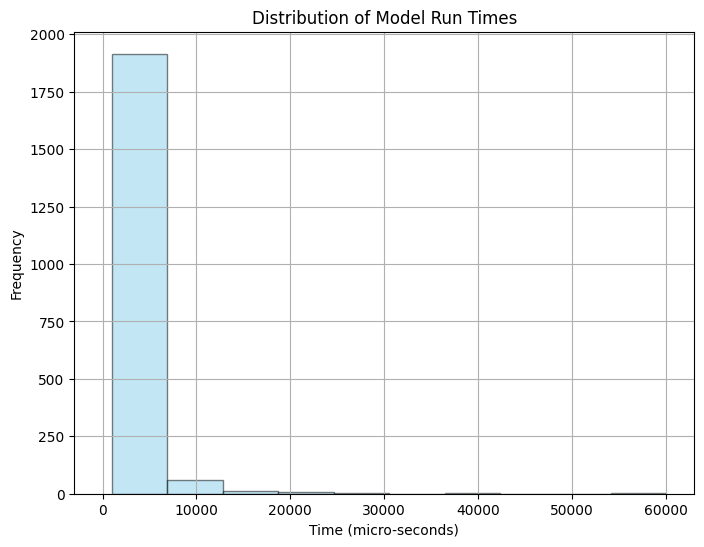

In [25]:
# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(list_compute_time, bins=10, edgecolor='black', color='skyblue', alpha=0.5)
plt.hist(list_compute_time_smaller, bins=10, edgecolor='black', color='red', alpha=0.5)
plt.title('Distribution of Model Run Times')
plt.xlabel('Time (micro-seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()